this notebook is a sample of our aproach to feature selection with associations rules. please run our code from [github](https://github.com/BergerZvika/Feature-Selection-with-Association-Rules) to see out website.



# Intilazation

Clone git repository

In [1]:
!git clone https://github.com/BergerZvika/Feature-Selection-with-Association-Rules.git


Cloning into 'Feature-Selection-with-Association-Rules'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 195 (delta 112), reused 32 (delta 19), pack-reused 0
Receiving objects: 100% (195/195), 9.11 MiB | 3.75 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
!pip install efficient_apriori
from efficient_apriori import apriori

from matplotlib import pyplot as plt
import pandas as pd

#machine learning
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


Configuration

In [3]:
PATH = 'Feature-Selection-with-Association-Rules/data/diamonds.csv'
predict_feature = 'price'
k = 7 # number of feature to select
model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
support = 0.01
confidence = 0.6

# Display database

In [4]:

def fillna(dataset):
    # Defining numeric and categorical columns
    numeric_columns = dataset.dtypes[(dataset.dtypes == "float64") | (dataset.dtypes == "int64")].index.tolist()
    very_numerical = [nc for nc in numeric_columns if dataset[nc].nunique() > 20]
    categorical_columns = [c for c in dataset.columns if c not in numeric_columns]
    ordinals = list(set(numeric_columns) - set(very_numerical))

    # Filling Null Values with the column's mean
    na_columns = dataset[very_numerical].isna().sum()
    na_columns = na_columns[na_columns > 0]
    for nc in na_columns.index:
        dataset[nc].fillna(dataset[nc].mean(), inplace=True)
    # Dropping and filling NA values for categorical columns:
    nul_cols = dataset[categorical_columns].isna().sum() / len(dataset)
    drop_us = nul_cols[nul_cols > 0.7]
    dataset = dataset.drop(drop_us.index, axis=1)
    categorical_columns = list(set(categorical_columns) - set(drop_us.index))
    dataset[categorical_columns] = dataset[categorical_columns].fillna('na')
    return dataset

df =  pd.read_csv(PATH, index_col=[0])
df = fillna(df)

In [5]:
df

,carat,cut,color,clarity,depth,table,x,y,z,price
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50,2757
53937,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61,2757
53938,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56,2757
53939,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74,2757


Split to train and Test

In [6]:
length = len(df)
dataset = df.sample(frac=1).reset_index(drop=True)
test = dataset[int(length / 5 * 4):]
dataset = dataset[:int(length / 5 * 4)]


# Find Associations Rules

In [8]:
dataset_rules = dataset.copy()
# Defining numeric and categorical columns
numeric_columns = dataset_rules.dtypes[(dataset_rules.dtypes == "float64") | (dataset_rules.dtypes == "int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dataset_rules[nc].nunique() > 20]

# Binning all numeric columns in the same manner:
for c in very_numerical:
    try:
        dataset_rules[c] = pd.qcut(dataset_rules[c], 5, labels=["very low", "low", "medium", "high", "very high"])
    except:
        # sometimes for highly skewed data, we cannot perform qcut as most quantiles are equal
        dataset_rules[c] = pd.cut(dataset_rules[c], 5, labels=["very low", "low", "medium", "high", "very high"])

records = dataset_rules.to_dict(orient='records')
transactions = []
for r in records:
  transactions.append(list(r.items()))

# Rules mining process:
itemsets, rules = apriori(transactions, min_support=support, min_confidence=confidence,
                                          output_transaction_ids=False)



In [9]:
len(rules)

58563

In [10]:
# Analyzing the rules:
attrs = [a for a in dir(rules[0]) if not a.startswith("_")]
rules_rec = []
for r in rules:
    rdict = {}
    for a in attrs:
        rdict[a] = getattr(r, a)
        rdict["rule"] = str(r).split("} (")[0] + "}"
        rdict["len_l"] = len(r.lhs)
        rdict["len_r"] = len(r.rhs)
    rules_rec.append(rdict)

rules_df = pd.DataFrame(rules_rec)
rules_df.set_index('rule', inplace=True)

In [11]:
rules_df

,confidence,len_l,len_r,conviction,count_full,count_lhs,count_rhs,lhs,lift,num_transactions,rhs,rpf,support
rule,,,,,,,,,,,,,
"{('price', 'high')} -> {('carat', 'high')}",0.616972,1,1,2.145939,5322,8626,7683,"((price, high),)",3.465258,43152,"((carat, high),)",0.076092,0.123331
"{('carat', 'high')} -> {('price', 'high')}",0.692698,1,1,2.603635,5322,7683,8626,"((carat, high),)",3.465258,43152,"((price, high),)",0.085431,0.123331
"{('x', 'high')} -> {('carat', 'high')}",0.844589,1,1,5.288914,7266,8603,7683,"((x, high),)",4.743682,43152,"((carat, high),)",0.142213,0.168382
"{('carat', 'high')} -> {('x', 'high')}",0.945724,1,1,14.751267,7266,7683,8603,"((carat, high),)",4.743682,43152,"((x, high),)",0.159243,0.168382
"{('y', 'high')} -> {('carat', 'high')}",0.829047,1,1,4.808078,7221,8710,7683,"((y, high),)",4.656389,43152,"((carat, high),)",0.138732,0.167339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{('carat', 'very low'), ('depth', 'medium'), ('price', 'very low'), ('table', 'very low')} -> {('cut', 'Ideal'), ('x', 'very low'), ('y', 'very low'), ('z', 'very low')}",0.848057,4,4,5.937165,720,849,4224,"((carat, very low), (depth, medium), (price, v...",8.663668,43152,"((cut, Ideal), (x, very low), (y, very low), (...",0.014150,0.016685
"{('carat', 'very low'), ('cut', 'Ideal'), ('depth', 'medium'), ('table', 'very low')} -> {('price', 'very low'), ('x', 'very low'), ('y', 'very low'), ('z', 'very low')}",0.616967,4,4,2.224742,720,1167,6380,"((carat, very low), (cut, Ideal), (depth, medi...",4.172938,43152,"((price, very low), (x, very low), (y, very lo...",0.010294,0.016685
"{('carat', 'very low'), ('cut', 'Ideal'), ('depth', 'medium'), ('price', 'very low')} -> {('table', 'very low'), ('x', 'very low'), ('y', 'very low'), ('z', 'very low')}",0.753927,4,4,3.692875,720,955,3939,"((carat, very low), (cut, Ideal), (depth, medi...",8.259316,43152,"((table, very low), (x, very low), (y, very lo...",0.012579,0.016685


# Feature Selection

In [22]:
def feature_selection(data):
    feature = set()
    for i in data.index:
      sp = i.split('->')
      left = sp[0]
      left = left.replace('{', '').replace('}', '').replace('(', '').replace('\'', '')
      left = left.split(',')
      i = 0
      while i < len(left) and len(feature) < k:
        f = left[i].strip()
        if f != predict_feature:
          feature.add(f)
        i += 2
    return list(feature)

support_feature = feature_selection(rules_df.sort_values('support', ascending=False))
confidence_feature = feature_selection(rules_df.sort_values('confidence', ascending=False))
lift_feature = feature_selection(rules_df.sort_values('lift', ascending=False))

feature_table = {'support' : support_feature,
                  'confidence' : confidence_feature,
                  'lift': lift_feature}

feature_data = pd.DataFrame(data=feature_table)


In [23]:
feature_data

,support,confidence,lift
0,x,x,x
1,cut,color,cut
2,table,table,table
3,depth,depth,carat
4,carat,carat,clarity
5,z,z,z
6,y,y,y


# Model Comparison

In [25]:
def evaluation(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    mse = mean_squared_error(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)
    return [mse, r2, [y_test, y_predict]]

# models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(n_estimators=100, max_depth=10),
              # AdaBoostRegressor(), xgb.XGBRegressor(objective="reg:linear", random_state=42)]

data_enconder_train = dataset.copy()
labelencoder = LabelEncoder()

numeric_columns = dataset.dtypes[(dataset.dtypes == "float64") | (dataset.dtypes == "int64")].index.tolist()
categorical_columns = [c for c in dataset.columns if c not in numeric_columns]
for c in categorical_columns:
    data_enconder_train[c] = labelencoder.fit_transform(data_enconder_train[c])

data_enconder_test = test.copy()
labelencoder = LabelEncoder()
for c in categorical_columns:
    data_enconder_test[c] = labelencoder.fit_transform(data_enconder_test[c])

x_train = data_enconder_train.drop(predict_feature, axis=1)
x_test = data_enconder_test.drop(predict_feature, axis=1)
y_train = data_enconder_train[predict_feature]
y_test = data_enconder_test[predict_feature]

x_train_support = x_train[feature_table['support']]
x_test_support = x_test[feature_table['support']]
x_train_confidence = x_train[feature_table['confidence']]
x_test_confidence = x_test[feature_table['confidence']]
x_train_lift = x_train[feature_table['lift']]
x_test_lift = x_test[feature_table['lift']]

mse_data, r2_data, eva_data = evaluation(model, x_train, x_test, y_train, y_test)
mse_support, r2_support, eva_support = evaluation(model, x_train_support, x_test_support, y_train, y_test)
mse_confidence, r2_confidence, eva_confidence = evaluation(model, x_train_confidence, x_test_confidence,
                                                                   y_train, y_test)
mse_lift, r2_lift, eva_lift = evaluation(model, x_train_lift, x_test_lift, y_train, y_test)



r2 = [r2_data, r2_support, r2_confidence, r2_lift]
mse = [mse_data, mse_support, mse_confidence, mse_lift]
data_table = {'Features': ['All Features', 'Select feature by support', 'Select feature by confidence',
                                   'Select feature by lift'],
                      'R-Square Score': r2,
                      'Mean Sqaure Error': mse,
                      }
table = pd.DataFrame(data_table, columns=['Features', 'R-Square Score', 'Mean Sqaure Error'])




[06:51:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:51:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:51:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:51:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
table

,Features,R-Square Score,Mean Sqaure Error
0,All Features,0.971137,4.499333e+05
1,Select feature by support,0.887305,1.756728e+06
2,Select feature by confidence,0.912839,1.358700e+06
3,Select feature by lift,0.940122,9.333924e+05


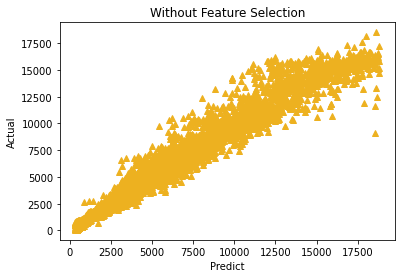

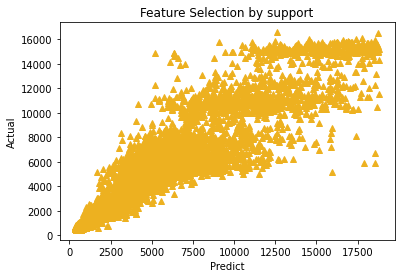

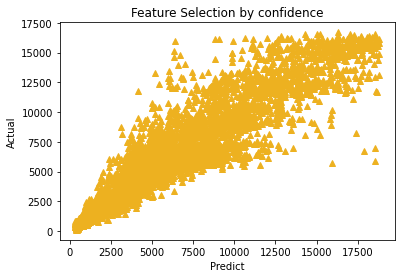

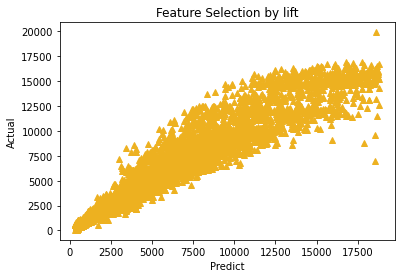

In [26]:
plt.plot(eva_data[0], eva_data[1], "^", color='#EDB120')
plt.ylabel("Actual")
plt.xlabel("Predict")
plt.title("Without Feature Selection")
plt.show()

plt.plot(eva_support[0], eva_support[1], "^", color='#EDB120')
plt.ylabel("Actual")
plt.xlabel("Predict")
plt.title("Feature Selection by support")
plt.show()


plt.plot(eva_confidence[0], eva_confidence[1], "^", color='#EDB120')
plt.ylabel("Actual")
plt.xlabel("Predict")
plt.title("Feature Selection by confidence")
plt.show()

plt.plot(eva_lift[0], eva_lift[1], "^", color='#EDB120')
plt.ylabel("Actual")
plt.xlabel("Predict")
plt.title("Feature Selection by lift")
plt.show()